# Chest X-Ray Images (Pneumonia)

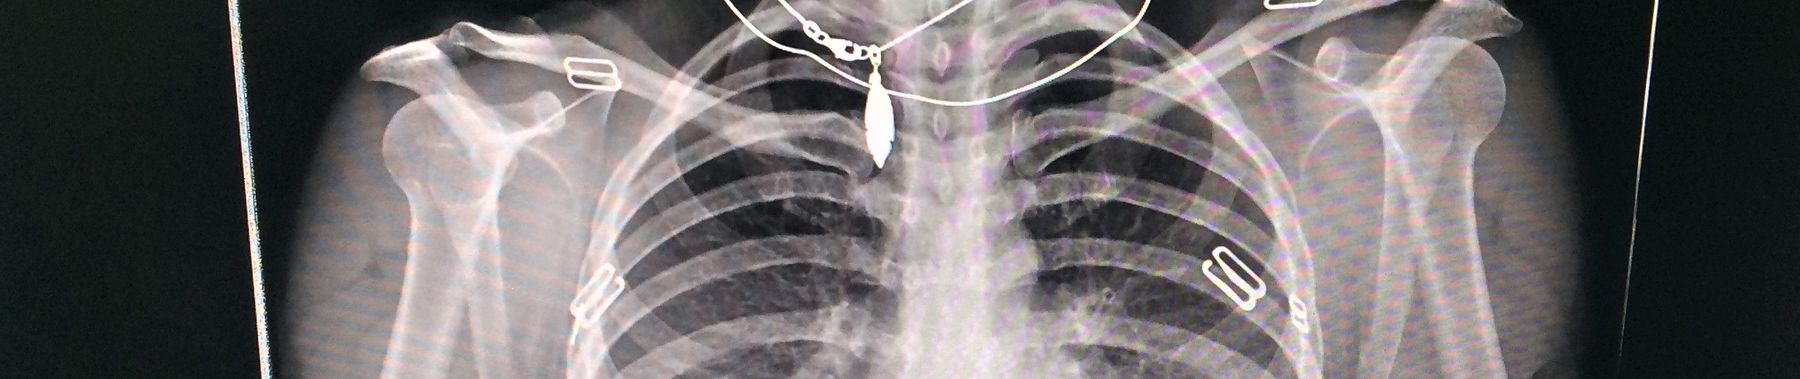

Kacey Clougher, Rachel Goldstein, Irwin Lam, and Kendall McNeil

DESCRIPTION: Pneumonia is an infection that affects one or both lungs by causing the air sacs, or alveoli, of the lungs to fill up with fluid or pus. Traditionally, pneumonia detection hinges on the examination of chest X-ray radiographs, a labor-intensive process conducted by highly skilled specialists. This method often results in discordant interpretations among radiologists. Leveraging the power of deep learning techniques (CNNs), we have developed a computational approach for the detection of pneumonia regions.

OBJECTIVE: Create a model that classifies x-ray images into two categories: Normal and Pneumonia. This information can be used by medical experts to assist in the diagnosis of pneumonia. 

METHODOLOGY: We used Convolutional Neural Network (CNN) techniques to develop an AI system for pneumonia detection. The neural network model or architecture was designed using the Keras API and was implemented using Python and TensorFlow.

DATA: The dataset was provided by Kaggle: [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia). It contains X-ray three folders/directories (train, test, val) of images divided into two categories: "Normal" and "Pneumonia." These images were acquired from pediatric patients aged one to five years at Guangzhou Women and Children's Medical Center. Before inclusion, a quality control process removed poor-quality scans, and expert physicians graded the diagnoses to prepare the dataset for AI training.

### Please note the following before proceeding: 
1. There are a few working copies of this notebook with more models, more paths we tried. We limited our final notebook for efficiency reasons. You can find the working notebooks in the individual branches on our Github repo.
2. Due to the random nature of neural networks, some models might not be producing the exact same results as in the working copies. 

# 1. Loading In and Exploring the Data

In [1]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np
import os
import tensorflow as tf
from keras import datasets, models, layers, optimizers, regularizers, callbacks
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report, recall_score, ConfusionMatrixDisplay
from keras.optimizers import SGD, Adam
from keras.metrics import Recall, Precision

%matplotlib inline
%load_ext autoreload
%autoreload 2

First, we need to create our directory paths to input into our image generators.
Then we need to create the datasets.

In [2]:
# Directory paths for train, test, and val
train_path = 'Data/chest_xray/train'
test_path = 'Data/chest_xray/test'
val_path = 'Data/chest_xray/val'

# Import the train directory data, which includes both normal and pneumonia (5216 total) and reshape them
train_generator = ImageDataGenerator(rescale=1.0/255).flow_from_directory(
        train_path, 
        target_size=(64, 64), batch_size=5216)

# Import the test directory data, which includes both normal and pneumonia (624 total) and reshape them
test_generator = ImageDataGenerator(rescale=1.0/255).flow_from_directory(
        test_path, 
        target_size=(64, 64), batch_size=624)

# Import the val directory data, which includes both normal and pneumonia (8 each - 16 total) and reshape them
val_generator = ImageDataGenerator(rescale=1.0/255).flow_from_directory(
        val_path, 
        target_size=(64, 64), batch_size=16)

# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


Note that we took care of standarizing the data by using rescale in our ImageDataGenerator functions. Each image takes a value between 0 and 255 so to standardize the data, we divided by 255.

Now that we have the data loaded in, let's take a look at some of the images from each dataset, just to check they loaded properly and are visible. 

First, let's look at a few train images: 

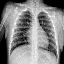

In [3]:
array_to_img(train_images[0])

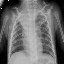

In [4]:
array_to_img(train_images[4])

Looks good! Now, let's look at some test images: 

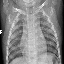

In [5]:
array_to_img(test_images[0])

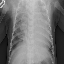

In [6]:
array_to_img(test_images[4])

Looks good! Finally, let's look at the validation images: 

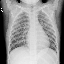

In [7]:
array_to_img(val_images[0])

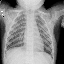

In [8]:
array_to_img(val_images[4])

Great! All of our pictures have loaded, and are visible. Let's check out the distribution of pneumonia vs. normal images in our train dataset. 

First, let's create paths to where the normal and pneumonia folders are saved. 

In [9]:
normal_train_path = 'Data/chest_xray/train/normal'
pneumonia_train_path = 'Data/chest_xray/train/pneumonia'

Next, let's count how many files are in each folder so that we can plot the distribution. 

In [10]:
normal_count = len(os.listdir(normal_train_path))
pneumonia_count = len(os.listdir(pneumonia_train_path))
print(f'normal: {normal_count}')
print(f'pneumonia: {pneumonia_count}')

normal: 1342
pneumonia: 3876


Finally, let's plot it!

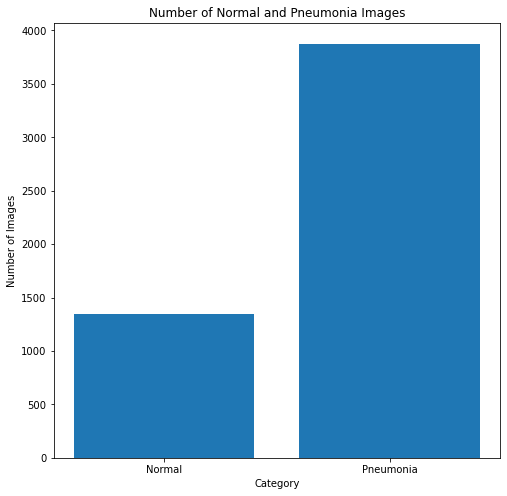

In [11]:
# plot the distribution
fig, ax = plt.subplots(figsize=(8,8))
plt.bar(x=['Normal', 'Pneumonia'], height=[normal_count, pneumonia_count])
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.title('Number of Normal and Pneumonia Images')
plt.show();

Here, we can clearly see that are a lot more images of pneumonia than there are images of normal chests. Since the model will always predict class 1, to prevent the model from just predicting pneumonia (the majority class) every time, it might be beneficial to switch the labels, so that our normal images are class 1, pneumonia is class 0, and our model is aiming to predict if an x-ray is normal.

Before we do anything, let's check out the shape of the datasets and see what we are working with. 

In [12]:
print(f"Train Images: {train_images.shape}")
print(f"Train Labels: {train_labels.shape}")
print(f"Test Images: {test_images.shape}")
print(f"Test Labels: {test_labels.shape}")
print(f"Val Images: {val_images.shape}")
print(f"Val Labels: {val_labels.shape}")

Train Images: (5216, 64, 64, 3)
Train Labels: (5216, 2)
Test Images: (624, 64, 64, 3)
Test Labels: (624, 2)
Val Images: (16, 64, 64, 3)
Val Labels: (16, 2)


Let's also look at the class indices to find out how are images are labeled. 

In [13]:
train_generator.class_indices 

{'NORMAL': 0, 'PNEUMONIA': 1}

Here, we'd like to point out a few things: 
1. There are two classes in our dataset: the first is normal, which is class 0, and the second is pneumonia, which is class 1. So, 0 represents a normal x-ray with no pneumonia and 1 represents an x-ray of a chest with pneumonia. 
2. The shape of the labels are (x, 2) where x represents the row and there are 2 columns. This represents the binary class labels, likely being represented as an array [0,1] or [1,0] with 0 representing normal and 1 representing pneumonia. 

Let's confirm #2, and then change the labels to be either 0 or 1 based on if the x-ray is normal or not. 

In [14]:
train_labels

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

Yes! Our labels are an array of [0,1] or [1,0]. We want our model to be a binary classification so let's change our labels to be binary instead. From earlier, we'd like normal to be class 1, so if we take the first row of the transposed dataset, it should correspond to normal.  

In [15]:
# transpose the train labels so we have two rows
# take the first row, which represents normal, and set that equal to our final labels
train_labels_final = train_labels.T[0]
test_labels_final = test_labels.T[0]
val_labels_final = val_labels.T[0]

print(f"Train Labels Updated Shape: {train_labels_final.shape}")
print(f"Test Labels Updated Shape: {test_labels_final.shape}")
print(f"Val Labels Updated Shape: {val_labels_final.shape}")

Train Labels Updated Shape: (5216,)
Test Labels Updated Shape: (624,)
Val Labels Updated Shape: (16,)


In [16]:
# check it out
train_labels_final

array([1., 0., 0., ..., 0., 0., 0.], dtype=float32)

Great! Just to be sure, let's confirm how many are labeled as 0 and how many are labeled as 1 so that we know what we're predicting. 

In [17]:
distribution = np.bincount(train_labels_final.astype(int))
print("Class 0 count:", distribution[0])
print("Class 1 count:", distribution[1])

Class 0 count: 3875
Class 1 count: 1341


Great! As there were 1341 images in the normal dataset, we can see clearly that this worked, and normal now corresponds to class 1. This should help our model not predict the majority class every time. 

Before we start the model building process, let's look at the percentage class distribution, as this will be our baseline accuracy that we need to beat. 

In [18]:
pd.Series(train_labels_final).value_counts(normalize=True)

0.0    0.742906
1.0    0.257094
dtype: float64

So, our dataset is made up of 75% pneumonia images, and 25% normal images. Since we're predicting class 1 (normal), 25% is the accuracy we need to beat. 

Let's get started with our first simple model!

# 2. First Simple Model

Let's build a first simple model with no hidden layers. We're going to use the sequential model from keras, as it allows us to stack layers one after the other. Starting with a dense layer with 10 units, relu activation as it will introduce some non-linearity into our model to help it learn complex patterns, and an input shape of (64, 64, 3). Then adding a flattening layer so that the output layer of the previous dense layer (which is 2D) is turned into a 1D tensor, which is what our output layer needs. Then we'll add a final dense layer with 1 unit and sigmoid activation, as that is what is suitable for binary classification. 

In [19]:
first_model = models.Sequential()
first_model.add(layers.Dense(10, activation='relu', input_shape=(64, 64, 3)))
first_model.add(layers.Flatten())
first_model.add(layers.Dense(1, activation='sigmoid'))

Let's compile the model using the adam optimizer, binary crossentropy as the loss, and accuracy as our metric. 
1. We chose adam because adam is an adaptive learning rate optimization algorithm that helps with efficient convergence. 
2. We chose binary crossentropy because this is a binary classification!
3. We would like to measure the accuracy in our results, hence our metric of choice. 

In [20]:
first_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Let's check out 

In [21]:
first_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64, 64, 10)        40        
_________________________________________________________________
flatten (Flatten)            (None, 40960)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 40961     
Total params: 41,001
Trainable params: 41,001
Non-trainable params: 0
_________________________________________________________________


Our model has 41,001 parameters, all trainable. Let's fit it on our train set, and see how it does. 

In [22]:
# ⏰ This cell may take about a minute to run
first_model.fit(train_images, train_labels_final, epochs=10, batch_size=64)

Epoch 1/10
82/82 [==============================] - 2s 19ms/step - loss: 0.4284 - accuracy: 0.8296
Epoch 2/10
82/82 [==============================] - 2s 23ms/step - loss: 0.2192 - accuracy: 0.9174
Epoch 3/10
82/82 [==============================] - 2s 23ms/step - loss: 0.1699 - accuracy: 0.9358
Epoch 4/10
82/82 [==============================] - 2s 23ms/step - loss: 0.1454 - accuracy: 0.9479
Epoch 5/10
82/82 [==============================] - 2s 23ms/step - loss: 0.1404 - accuracy: 0.9465
Epoch 6/10
82/82 [==============================] - 2s 23ms/step - loss: 0.1443 - accuracy: 0.9479
Epoch 7/10
82/82 [==============================] - 2s 23ms/step - loss: 0.1177 - accuracy: 0.9569
Epoch 8/10
82/82 [==============================] - 2s 23ms/step - loss: 0.1181 - accuracy: 0.9544
Epoch 9/10
82/82 [==============================] - ETA: 0s - loss: 0.1291 - accuracy: 0.95 - 2s 23ms/step - loss: 0.1296 - accuracy: 0.9500
Epoch 10/10
82/82 [==============================] - 2s 23ms/step -

In [23]:
train_loss, train_acc = first_model.evaluate(train_images, train_labels_final)

163/163 [==============================] - 1s 5ms/step - loss: 0.1440 - accuracy: 0.9444


In [24]:
test_loss, test_acc = first_model.evaluate(test_images, test_labels_final)

20/20 [==============================] - 0s 6ms/step - loss: 1.2919 - accuracy: 0.6955


We have a train score of 94% and a test score of 70%. This is nice and overfit! Let's try using a Conv2D layer to start, and add a hiden Conv2D layer, and see if that helps improve our accuracy. 

Since we have a relatively smaller dataset, we're going to use 32 filters for our first convolutional layer. This means that we have 32 "detectors", each looking for a different pattern in the images. Let's keep relu activation for now in our first and hidden layer, and keep sigmoid as our output activation. 

In [25]:
second_model = models.Sequential()
second_model.add(layers.Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(64, 64, 3)))

second_model.add(layers.Conv2D(64, (3, 3), activation='relu'))

second_model.add(layers.Flatten())
second_model.add(layers.Dense(1, activation='sigmoid')) 

Compile the model the same way as before - adam optimizer, binary crossentropy as the loss, and accuracy as our metric. Then, fit it on our training data. 

In [26]:
second_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [27]:
second_model.fit(train_images,train_labels_final,epochs=10,batch_size=64)

Epoch 1/10
82/82 [==============================] - 37s 450ms/step - loss: 0.4024 - accuracy: 0.8512
Epoch 2/10
82/82 [==============================] - 33s 400ms/step - loss: 0.1228 - accuracy: 0.9517
Epoch 3/10
82/82 [==============================] - 31s 379ms/step - loss: 0.0903 - accuracy: 0.9680
Epoch 4/10
82/82 [==============================] - 30s 369ms/step - loss: 0.0730 - accuracy: 0.9735
Epoch 5/10
82/82 [==============================] - 30s 372ms/step - loss: 0.0518 - accuracy: 0.9804
Epoch 6/10
82/82 [==============================] - 31s 373ms/step - loss: 0.0516 - accuracy: 0.9814
Epoch 7/10
82/82 [==============================] - 33s 402ms/step - loss: 0.0441 - accuracy: 0.9847
Epoch 8/10
82/82 [==============================] - 31s 380ms/step - loss: 0.0294 - accuracy: 0.9902
Epoch 9/10
82/82 [==============================] - 30s 372ms/step - loss: 0.0181 - accuracy: 0.9942
Epoch 10/10
82/82 [==============================] - 31s 375ms/step - loss: 0.0112 - accura

In [28]:
train_loss, train_acc = second_model.evaluate(train_images, train_labels_final)

163/163 [==============================] - 10s 63ms/step - loss: 0.0077 - accuracy: 0.9983


In [29]:
test_loss, test_acc = second_model.evaluate(test_images, test_labels_final)

20/20 [==============================] - 1s 54ms/step - loss: 2.0863 - accuracy: 0.7179


We have a train score of nearly 1, and a test score of about 72%. The test score is better, but the train score is even more overfit than before! Let's try adding regularization next. 

Before we do that, however, we're going to be checking scores quite a lot. So, let's define a function to evaluate our models for moving forward.

In [30]:
def evaluate(model):
    model_results_train = model.evaluate(train_images, train_labels_final)
    print(f'Training Loss: {model_results_train[0]:.3} \nTraining Accuracy: {model_results_train[1]:.3}')

    print('----------')

    model_results_test = model.evaluate(test_images, test_labels_final)
    print(f'Test Loss: {model_results_test[0]:.3} \nTest Accuracy: {model_results_test[1]:.3}') 

Let's just check that this function works by using it on our second model, and comparing to the manually calculated results above. 

In [31]:
evaluate(second_model)

163/163 [==============================] - 11s 67ms/step - loss: 0.0077 - accuracy: 0.9983
Training Loss: 0.00774 
Training Accuracy: 0.998
----------
20/20 [==============================] - 1s 57ms/step - loss: 2.0863 - accuracy: 0.7179
Test Loss: 2.09 
Test Accuracy: 0.718


Great! Our function works. As mentioned before, our model is very overfit, and we'd like to add regularization to see if it improves performance. 

Let's start with L2 regularization. L2 (or Ridge regularization) works by adding a penalty term to the loss function, which in turn makes the models weights smaller. It effectively limits the models capacity, which reduces overfitting. It also improves generalization - the limit of the weights helps the models performance with unseen data. It's important to note that L2 regularization drives the weights towards 0, reducing their influence on the models predicitons. 

Let's use our second_model, and just adjust it to include regularization. Let's start with a smaller strength of 0.005.

In [32]:
third_model = models.Sequential()

third_model.add(layers.Conv2D(filters=32, kernel_size=(3, 3),
                               activation='relu', kernel_regularizer=regularizers.l2(0.005), 
                               input_shape=(64, 64, 3)))

third_model.add(layers.Flatten())
third_model.add(layers.Dense(1, activation='sigmoid'))

Compile the model using adam, binary crossentropy, and accuracy once more. 

In [33]:
third_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Fit the model on our train data and let's analyze the results. 

In [34]:
# ⏰ This cell may take about a minute to run
third_model_results = third_model.fit(train_images,train_labels_final,epochs=10,batch_size=64)

Epoch 1/10
82/82 [==============================] - 6s 72ms/step - loss: 0.3890 - accuracy: 0.8574
Epoch 2/10
82/82 [==============================] - 6s 69ms/step - loss: 0.1471 - accuracy: 0.9572
Epoch 3/10
82/82 [==============================] - 5s 67ms/step - loss: 0.1149 - accuracy: 0.9703
Epoch 4/10
82/82 [==============================] - 5s 66ms/step - loss: 0.0994 - accuracy: 0.9730
Epoch 5/10
82/82 [==============================] - 6s 68ms/step - loss: 0.0852 - accuracy: 0.9789
Epoch 6/10
82/82 [==============================] - 5s 66ms/step - loss: 0.0760 - accuracy: 0.9831
Epoch 7/10
82/82 [==============================] - 5s 66ms/step - loss: 0.0755 - accuracy: 0.9843
Epoch 8/10
82/82 [==============================] - 5s 67ms/step - loss: 0.0600 - accuracy: 0.9889
Epoch 9/10
82/82 [==============================] - 5s 66ms/step - loss: 0.0519 - accuracy: 0.9939
Epoch 10/10
82/82 [==============================] - 6s 70ms/step - loss: 0.0454 - accuracy: 0.9964


In [35]:
# ⏰ This cell may take about a minute to run
evaluate(third_model)

163/163 [==============================] - 3s 16ms/step - loss: 0.0521 - accuracy: 0.9941
Training Loss: 0.0521 
Training Accuracy: 0.994
----------
20/20 [==============================] - 0s 18ms/step - loss: 0.7699 - accuracy: 0.7901
Test Loss: 0.77 
Test Accuracy: 0.79


This model is a little bit better than the previous two, but not a whole lot. Our train score is still nearly 1 (99%), and our test score is 79%. This test score is an improvement, but as our train score is 20% higher, this model is still very overfit.

Let's try adding dropout regularization. Dropout works by randomly deactivating (or "dropping out") a certain number of units (or neurons) during each forward/backward propagation of training. This introduces some randomness into our model, and helps prevent any one neuron from being too over-trained. This ultimately helps the model generalize better to unseen data. 

So, let's see if it helps! Let's also add a few more hidden layers, as more complexity should help generalization. We'll add both convolutional and pooling layers. The pooling layers aim to reduce the spacial dimensions of the feature maps created by the convolutional layers. It preserves the most important pieces of information from the feature maps. 

In [36]:
#DROPOUT METHOD TO MITIGATE THE IMPACTS OF OVERFITTING
# ⏰ This cell may take about a minute to run
fourth_model = models.Sequential()

# Implement dropout to the input layer
# NOTE: This is where you define the number of units in the input layer
fourth_model.add(layers.Dropout(0.3, input_shape=(64,64,3)))

# Add the first hidden layer
fourth_model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))

# Implement dropout to the first hidden layer 
fourth_model.add(layers.Dropout(.3))

# Add the second hidden layer
fourth_model.add(layers.MaxPooling2D(pool_size=(2,2)))
fourth_model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Implement dropout to the second hidden layer 
fourth_model.add(layers.Dropout(.3))

# Add the output layer
fourth_model.add(layers.Flatten())
fourth_model.add(layers.Dense(1, activation='sigmoid'))

Next, let's compile, fit, and evaluate our model!

In [37]:
fourth_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [38]:
# ⏰ This cell may take about a minute to run
fourth_model_results = fourth_model.fit(train_images,train_labels_final,epochs=10,batch_size=64)

Epoch 1/10
82/82 [==============================] - 26s 321ms/step - loss: 0.4745 - accuracy: 0.7793
Epoch 2/10
82/82 [==============================] - 24s 296ms/step - loss: 0.1979 - accuracy: 0.9241
Epoch 3/10
82/82 [==============================] - 24s 293ms/step - loss: 0.1484 - accuracy: 0.9459
Epoch 4/10
82/82 [==============================] - 28s 340ms/step - loss: 0.1351 - accuracy: 0.9480
Epoch 5/10
82/82 [==============================] - 26s 319ms/step - loss: 0.1195 - accuracy: 0.9551
Epoch 6/10
82/82 [==============================] - 27s 335ms/step - loss: 0.1208 - accuracy: 0.9538
Epoch 7/10
82/82 [==============================] - 25s 300ms/step - loss: 0.1139 - accuracy: 0.9553
Epoch 8/10
82/82 [==============================] - 24s 297ms/step - loss: 0.0985 - accuracy: 0.9618
Epoch 9/10
82/82 [==============================] - 24s 294ms/step - loss: 0.0947 - accuracy: 0.9640
Epoch 10/10
82/82 [==============================] - 24s 295ms/step - loss: 0.0894 - accura

In [39]:
# ⏰ This cell may take about a minute to run
evaluate(fourth_model)

163/163 [==============================] - 4s 27ms/step - loss: 0.1119 - accuracy: 0.9707
Training Loss: 0.112 
Training Accuracy: 0.971
----------
20/20 [==============================] - 0s 24ms/step - loss: 0.6042 - accuracy: 0.7228
Test Loss: 0.604 
Test Accuracy: 0.723


Okay, so that didn't help. Interesting. Our train score is slightly lower at 97%, and our test  score is back down to 72%. So this isn't any better or worse than our previous models. 

Let's try adding an additional hidden layer and see if the increased complexity helps. We'd also like to try switching the activation function to tanh instead of relu and see if that helps anything. 

Tanh has similar properties to the sigmoid activation function, but rather than range from (0,1) like sigmoid, it ranges from (-1, 1), making it centered around zero. 

In [48]:
fifth_model = models.Sequential()

fifth_model.add(layers.Dropout(.3, input_shape=(64,64,3)))

# Add the first hidden layer
fifth_model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='tanh'))

# Implement dropout to the first hidden layer 
fifth_model.add(layers.Dropout(.3))

# Add the second hidden layer
fifth_model.add(layers.MaxPooling2D(pool_size=(2,2)))
fifth_model.add(layers.Conv2D(64, (3, 3), activation='tanh'))

# Implement dropout to the second hidden layer 
fifth_model.add(layers.Dropout(.3))

# Add the third hidden layer
fifth_model.add(layers.MaxPooling2D(pool_size=(2,2)))
fifth_model.add(layers.Conv2D(64, (3, 3), activation='tanh'))

# Implement dropout to the third hidden layer 
fifth_model.add(layers.Dropout(.3))

# Add the output layer
fifth_model.add(layers.Flatten())
fifth_model.add(layers.Dense(1, activation='tanh'))

Compile, fit, and evaluate the model!

In [49]:
fifth_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [50]:
# ⏰ This cell may take about a minute to run
fifth_model_results = fifth_model.fit(train_images,train_labels_final,epochs=20,batch_size=64)

Epoch 1/20
82/82 [==============================] - 31s 374ms/step - loss: 3.8953 - accuracy: 0.7322
Epoch 2/20
82/82 [==============================] - 29s 349ms/step - loss: 3.9657 - accuracy: 0.7429
Epoch 3/20
82/82 [==============================] - 28s 347ms/step - loss: 3.9657 - accuracy: 0.7429
Epoch 4/20
82/82 [==============================] - 29s 348ms/step - loss: 3.9657 - accuracy: 0.7429
Epoch 5/20
82/82 [==============================] - 30s 365ms/step - loss: 3.9657 - accuracy: 0.7429
Epoch 6/20
82/82 [==============================] - 28s 347ms/step - loss: 3.9657 - accuracy: 0.7429
Epoch 7/20
82/82 [==============================] - 29s 352ms/step - loss: 3.9657 - accuracy: 0.7429
Epoch 8/20
82/82 [==============================] - 28s 346ms/step - loss: 3.9657 - accuracy: 0.7429
Epoch 9/20
82/82 [==============================] - 29s 349ms/step - loss: 3.9657 - accuracy: 0.7429
Epoch 10/20
82/82 [==============================] - 28s 343ms/step - loss: 3.9657 - accura

In [51]:
# ⏰ This cell may take about a minute to run
evaluate(fifth_model)

163/163 [==============================] - 6s 38ms/step - loss: 0.7872 - accuracy: 0.7429
Training Loss: 0.787 
Training Accuracy: 0.743
----------
20/20 [==============================] - 1s 37ms/step - loss: 0.8858 - accuracy: 0.6250
Test Loss: 0.886 
Test Accuracy: 0.625


Interesting! This is much less overfit than before (but definitely still overfit). We have a train score of 74%, and a test score of 63%. Our model is doing a little better at generalizing, the delta between train and test scores being the lowest it's been so far. 

It's interesting that the train score dropped so much. Let's try less layers to see if maybe we made our model too complex. Let's also change the output activation function back to sigmoid from tanh and see if that makes a difference. 

In [52]:
sixth_model = models.Sequential()

sixth_model.add(layers.Dropout(.3, input_shape=(64,64,3)))

# Add the first hidden layer
sixth_model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='tanh'))

# Implement dropout to the first hidden layer 
sixth_model.add(layers.Dropout(.3))

# Add the second hidden layer
sixth_model.add(layers.MaxPooling2D(pool_size=(2,2)))
sixth_model.add(layers.Conv2D(64, (3, 3), activation='tanh'))

# Implement dropout to the second hidden layer 
sixth_model.add(layers.Dropout(.3))

# Add the output layer
sixth_model.add(layers.Flatten())
sixth_model.add(layers.Dense(1, activation='sigmoid'))

In [53]:
sixth_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [54]:
# ⏰ This cell may take about a minute to run
sixth_model_results = sixth_model.fit(train_images,train_labels_final,epochs=20,batch_size=64)

Epoch 1/20
82/82 [==============================] - 29s 349ms/step - loss: 0.4554 - accuracy: 0.8102
Epoch 2/20
82/82 [==============================] - 28s 338ms/step - loss: 0.1769 - accuracy: 0.9317
Epoch 3/20
82/82 [==============================] - 27s 333ms/step - loss: 0.1489 - accuracy: 0.9429
Epoch 4/20
82/82 [==============================] - 28s 338ms/step - loss: 0.1424 - accuracy: 0.9434
Epoch 5/20
82/82 [==============================] - 28s 341ms/step - loss: 0.1242 - accuracy: 0.9536
Epoch 6/20
82/82 [==============================] - 27s 333ms/step - loss: 0.1238 - accuracy: 0.9528
Epoch 7/20
82/82 [==============================] - 27s 335ms/step - loss: 0.1115 - accuracy: 0.9559
Epoch 8/20
82/82 [==============================] - 27s 327ms/step - loss: 0.1140 - accuracy: 0.9561
Epoch 9/20
82/82 [==============================] - 31s 377ms/step - loss: 0.1069 - accuracy: 0.9586
Epoch 10/20
82/82 [==============================] - 28s 340ms/step - loss: 0.0960 - accura

In [55]:
# ⏰ This cell may take about a minute to run
evaluate(sixth_model)

163/163 [==============================] - 5s 31ms/step - loss: 0.2180 - accuracy: 0.9160
Training Loss: 0.218 
Training Accuracy: 0.916
----------
20/20 [==============================] - 1s 27ms/step - loss: 1.3106 - accuracy: 0.6907
Test Loss: 1.31 
Test Accuracy: 0.691


Okay, so that didn't work exactly as expected. Both our train and test scores are higher, with train being 92% and test being 70%. So it helped raise scores, but once again, we are overfit. 

At this point, it's pretty clear that neural networks are very prone to overfitting. Since L2 and dropout regularization don't seem to quite enough, let's try implementing early stopping to avoid overfitting. Early stopping is a regularization technique that aims to prevent overfitting and improve generalization by stopping the training process once the models performance starts to deteriorate. This can be a powerful technique because stopping the process early stops the model from over-learning on the same data. 

In [56]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

early = EarlyStopping(monitor='loss', mode='min', patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [early, learning_rate_reduction]

In [57]:
# ⏰ This cell may take about a minute to run
early_stopping = sixth_model.fit(train_images,train_labels_final,epochs=10, callbacks=callbacks_list)

Epoch 1/10
163/163 [==============================] - 31s 192ms/step - loss: 0.1126 - accuracy: 0.9563
Epoch 2/10
163/163 [==============================] - 31s 193ms/step - loss: 0.1095 - accuracy: 0.9613
Epoch 3/10
163/163 [==============================] - 29s 177ms/step - loss: 0.1052 - accuracy: 0.9632
Epoch 4/10
163/163 [==============================] - 29s 179ms/step - loss: 0.1035 - accuracy: 0.9607
Epoch 5/10
163/163 [==============================] - 31s 187ms/step - loss: 0.1156 - accuracy: 0.9609
Epoch 6/10
163/163 [==============================] - 31s 190ms/step - loss: 0.1029 - accuracy: 0.9634
Epoch 7/10
163/163 [==============================] - 31s 191ms/step - loss: 0.1034 - accuracy: 0.9651
Epoch 8/10
163/163 [==============================] - ETA: 0s - loss: 0.1049 - accuracy: 0.9632
Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 31s 189ms/step - loss: 0.1049 - accuracy: 0.9632
Epoch 9/10


In [58]:
# ⏰ This cell may take about a minute to run
early_stopping_train = sixth_model.evaluate(train_images, train_labels_final)
print(f'Training Loss: {early_stopping_train[0]:.3} \nTraining Accuracy: {early_stopping_train[1]:.3}')

print('----------')

early_stopping_test = sixth_model.evaluate(test_images, test_labels_final)
print(f'Test Loss: {early_stopping_test[0]:.3} \nTest Accuracy: {early_stopping_test[1]:.3}') 

163/163 [==============================] - 5s 33ms/step - loss: 0.2765 - accuracy: 0.8993
Training Loss: 0.276 
Training Accuracy: 0.899
----------
20/20 [==============================] - 1s 30ms/step - loss: 0.6649 - accuracy: 0.7933
Test Loss: 0.665 
Test Accuracy: 0.793


Wow! This is so much better! We have a train score of 90% and a test score of 80%. This is now our best model. It has the smallest delta with the highest accuracy scores. Unsurprisingly, it's still a tad overfit. Let's see if we can do any better. 

Let's try a model with a few hidden layers, implementing dropout after each layer, all using relu activation, with tanh in the output layer. We're curious about the effect of the different activation functions on different layers. 

In [59]:
seventh_model = models.Sequential()

seventh_model.add(layers.Dropout(.3, input_shape=(64,64,3)))

# Add the first hidden layer
seventh_model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))

# Implement dropout to the first hidden layer 
seventh_model.add(layers.Dropout(.3))

# Add the second hidden layer
seventh_model.add(layers.MaxPooling2D(pool_size=(2,2)))
seventh_model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Implement dropout to the second hidden layer 
seventh_model.add(layers.Dropout(.3))

# Add the third hidden layer
seventh_model.add(layers.MaxPooling2D(pool_size=(2,2)))
seventh_model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Implement dropout to the third hidden layer 
seventh_model.add(layers.Dropout(.3))

# Add the output layer
seventh_model.add(layers.Flatten())
seventh_model.add(layers.Dense(1, activation='tanh'))

In [60]:
seventh_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [61]:
# ⏰ This cell may take about a minute to run
seventh_model_results = seventh_model.fit(train_images,train_labels_final,epochs=20,batch_size=64)

Epoch 1/20
82/82 [==============================] - 35s 422ms/step - loss: 0.6315 - accuracy: 0.7299
Epoch 2/20
82/82 [==============================] - 30s 372ms/step - loss: 0.3558 - accuracy: 0.8781
Epoch 3/20
82/82 [==============================] - 31s 375ms/step - loss: 0.4498 - accuracy: 0.8113
Epoch 4/20
82/82 [==============================] - 32s 388ms/step - loss: 0.5005 - accuracy: 0.8073
Epoch 5/20
82/82 [==============================] - 28s 342ms/step - loss: 0.2870 - accuracy: 0.9043
Epoch 6/20
82/82 [==============================] - 28s 339ms/step - loss: 0.2772 - accuracy: 0.9041
Epoch 7/20
82/82 [==============================] - 28s 342ms/step - loss: 0.2808 - accuracy: 0.9155
Epoch 8/20
82/82 [==============================] - 30s 370ms/step - loss: 0.2628 - accuracy: 0.9256
Epoch 9/20
82/82 [==============================] - 33s 403ms/step - loss: 0.3410 - accuracy: 0.8796
Epoch 10/20
82/82 [==============================] - 31s 382ms/step - loss: 0.3371 - accura

In [62]:
# ⏰ This cell may take about a minute to run
evaluate(seventh_model)

163/163 [==============================] - 6s 35ms/step - loss: 3.9657 - accuracy: 0.7429
Training Loss: 3.97 
Training Accuracy: 0.743
----------
20/20 [==============================] - 1s 31ms/step - loss: 5.7844 - accuracy: 0.6250
Test Loss: 5.78 
Test Accuracy: 0.625


This didn't really improve anything, maybe the combination of relu in the hidden layers and tanh in the output layer is inefficient. Our train score is back down to 74%, and our test score is at 63%. We can do better. 

Let's try tanh in the hidden layers, and sigmoid in the output layer. 

In [63]:
eighth_model = models.Sequential()

eighth_model.add(layers.Dropout(.3, input_shape=(64,64,3)))

# Add the first hidden layer
eighth_model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='tanh'))

# Implement dropout to the first hidden layer 
eighth_model.add(layers.Dropout(.3))

# Add the second hidden layer
eighth_model.add(layers.MaxPooling2D(pool_size=(2,2)))
eighth_model.add(layers.Conv2D(64, (3, 3), activation='tanh'))

# Implement dropout to the second hidden layer 
eighth_model.add(layers.Dropout(.3))

# Add the third hidden layer
eighth_model.add(layers.MaxPooling2D(pool_size=(2,2)))
eighth_model.add(layers.Conv2D(64, (3, 3), activation='tanh'))

# Implement dropout to the third hidden layer 
eighth_model.add(layers.Dropout(.3))

# Add the output layer
eighth_model.add(layers.Flatten())
eighth_model.add(layers.Dense(1, activation='sigmoid'))

In [64]:
eighth_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_18 (Dropout)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
dropout_19 (Dropout)         (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
dropout_20 (Dropout)         (None, 29, 29, 64)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 64)       

We have 65,537 parameters to train. Let's compile, fit, and evaluate our model. 

In [65]:
eighth_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [66]:
# ⏰ This cell may take about a minute to run
eighth_model_results = eighth_model.fit(train_images,train_labels_final,epochs=20,batch_size=64)

Epoch 1/20
82/82 [==============================] - 29s 359ms/step - loss: 0.4349 - accuracy: 0.7993
Epoch 2/20
82/82 [==============================] - 32s 395ms/step - loss: 0.1831 - accuracy: 0.9273
Epoch 3/20
82/82 [==============================] - 32s 389ms/step - loss: 0.1449 - accuracy: 0.9442
Epoch 4/20
82/82 [==============================] - 33s 398ms/step - loss: 0.1359 - accuracy: 0.9471
Epoch 5/20
82/82 [==============================] - 34s 419ms/step - loss: 0.1257 - accuracy: 0.9534
Epoch 6/20
82/82 [==============================] - 35s 421ms/step - loss: 0.1290 - accuracy: 0.9488
Epoch 7/20
82/82 [==============================] - 31s 382ms/step - loss: 0.1212 - accuracy: 0.9555
Epoch 8/20
82/82 [==============================] - 31s 383ms/step - loss: 0.1188 - accuracy: 0.9548
Epoch 9/20
82/82 [==============================] - 35s 426ms/step - loss: 0.1117 - accuracy: 0.9559
Epoch 10/20
82/82 [==============================] - 33s 407ms/step - loss: 0.1141 - accura

In [67]:
# ⏰ This cell may take about a minute to run
evaluate(eighth_model)

163/163 [==============================] - 6s 39ms/step - loss: 1.1183 - accuracy: 0.5928
Training Loss: 1.12 
Training Accuracy: 0.593
----------
20/20 [==============================] - 1s 38ms/step - loss: 0.7015 - accuracy: 0.7147
Test Loss: 0.701 
Test Accuracy: 0.715


This now looks underfit! We have a train score of 60%, and a test score of 71%. 

Let's try tanh as the activation function again, and reduce the amount of hidden layers. We'd like to point out that here, with all the switching back and forth between number of layers and activation function, that we are trying to find out which activation function is the most effective, and the optimal number of hidden layers to introduce the right amount of complexity into our model. We're also keeping dropout as that seemed more effective than L2 regularization at helping reduce overfitting. 

Let's see if this next model does any better. 

In [68]:
ninth_model = models.Sequential()

ninth_model.add(layers.Dropout(.3, input_shape=(64,64,3)))

# Add the first hidden layer
ninth_model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='tanh'))

# Implement dropout to the first hidden layer 
ninth_model.add(layers.Dropout(.3))

# Add the second hidden layer
ninth_model.add(layers.MaxPooling2D(pool_size=(2,2)))
ninth_model.add(layers.Conv2D(64, (3, 3), activation='tanh'))

# Implement dropout to the second hidden layer 
ninth_model.add(layers.Dropout(.3))

# Add the output layer
ninth_model.add(layers.Flatten())
ninth_model.add(layers.Dense(1, activation='tanh'))

In [69]:
ninth_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [70]:
# ⏰ This cell may take about a minute to run
ninth_model_results = ninth_model.fit(train_images,train_labels_final,epochs=20,batch_size=64)

Epoch 1/20
82/82 [==============================] - 28s 342ms/step - loss: 3.9318 - accuracy: 0.7408
Epoch 2/20
82/82 [==============================] - 29s 358ms/step - loss: 3.9657 - accuracy: 0.7429
Epoch 3/20
82/82 [==============================] - 29s 349ms/step - loss: 3.9657 - accuracy: 0.7429
Epoch 4/20
82/82 [==============================] - 27s 327ms/step - loss: 3.9657 - accuracy: 0.7429
Epoch 5/20
82/82 [==============================] - 27s 335ms/step - loss: 3.9657 - accuracy: 0.7429
Epoch 6/20
82/82 [==============================] - 30s 362ms/step - loss: 3.9657 - accuracy: 0.7429
Epoch 7/20
82/82 [==============================] - 30s 364ms/step - loss: 3.9657 - accuracy: 0.7429
Epoch 8/20
82/82 [==============================] - 30s 360ms/step - loss: 3.9657 - accuracy: 0.7429
Epoch 9/20
82/82 [==============================] - 31s 379ms/step - loss: 3.9657 - accuracy: 0.7429
Epoch 10/20
82/82 [==============================] - 28s 340ms/step - loss: 3.9657 - accura

In [71]:
# ⏰ This cell may take about a minute to run
evaluate(ninth_model)

163/163 [==============================] - 5s 30ms/step - loss: 3.9657 - accuracy: 0.7429
Training Loss: 3.97 
Training Accuracy: 0.743
----------
20/20 [==============================] - 1s 26ms/step - loss: 5.7844 - accuracy: 0.6250
Test Loss: 5.78 
Test Accuracy: 0.625


About the same as the results we've been seeing. Train score is about 74%, and test score is about 63%. The difference between the scores is at least not getting larger. This model is, like the others, overfit. 

Let's see what impact adding dense layers after our flatten layer has. When you add dense layers, they connect every neuron from the previous layer to the current layer, regardless of the number of neurons in each layers, and forming fully connected layers. When added after the flatten layer in a classification model, they are used to make predictions by learning all of the features extracted from the earlier hidden layers, which should increase accuracy in the predictions. 

Let's check it out:

In [72]:
tenth_model = models.Sequential()

tenth_model.add(layers.Dropout(.3, input_shape=(64,64,3)))

# Add the first hidden layer
tenth_model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='tanh'))

# Implement dropout to the first hidden layer 
tenth_model.add(layers.Dropout(.3))

# Add the second hidden layer
tenth_model.add(layers.MaxPooling2D(pool_size=(2,2)))
tenth_model.add(layers.Conv2D(64, (3, 3), activation='tanh'))

# Implement dropout to the second hidden layer 
tenth_model.add(layers.Dropout(.3))

# Add the third hidden layer
tenth_model.add(layers.MaxPooling2D(pool_size=(2,2)))
tenth_model.add(layers.Conv2D(64, (3, 3), activation='tanh'))

# Implement dropout to the third hidden layer 
tenth_model.add(layers.Dropout(.3))

# Add the output layer
tenth_model.add(layers.Flatten())
tenth_model.add(layers.Dense(128, activation='tanh'))
tenth_model.add(layers.Dropout(.3))
tenth_model.add(layers.Dense(64, activation='tanh'))
tenth_model.add(layers.Dense(1, activation='sigmoid'))

In [73]:
tenth_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [74]:
# ⏰ This cell may take about a minute to run
tenth_model_results = tenth_model.fit(train_images,train_labels_final,epochs=20,batch_size=64)

Epoch 1/20
82/82 [==============================] - 31s 382ms/step - loss: 0.5947 - accuracy: 0.7423
Epoch 2/20
82/82 [==============================] - 35s 426ms/step - loss: 0.5767 - accuracy: 0.7429
Epoch 3/20
82/82 [==============================] - 34s 418ms/step - loss: 0.5710 - accuracy: 0.7429
Epoch 4/20
82/82 [==============================] - 36s 436ms/step - loss: 0.5743 - accuracy: 0.7429
Epoch 5/20
82/82 [==============================] - 36s 435ms/step - loss: 0.5720 - accuracy: 0.7429
Epoch 6/20
82/82 [==============================] - 34s 418ms/step - loss: 0.5717 - accuracy: 0.7429
Epoch 7/20
82/82 [==============================] - 32s 389ms/step - loss: 0.5711 - accuracy: 0.7429
Epoch 8/20
82/82 [==============================] - 31s 380ms/step - loss: 0.5711 - accuracy: 0.7429
Epoch 9/20
82/82 [==============================] - 34s 410ms/step - loss: 0.5714 - accuracy: 0.7429
Epoch 10/20
82/82 [==============================] - 37s 454ms/step - loss: 0.5717 - accura

In [75]:
# ⏰ This cell may take about a minute to run
evaluate(tenth_model)

163/163 [==============================] - 6s 37ms/step - loss: 0.5701 - accuracy: 0.7429
Training Loss: 0.57 
Training Accuracy: 0.743
----------
20/20 [==============================] - 1s 46ms/step - loss: 0.6915 - accuracy: 0.6250
Test Loss: 0.691 
Test Accuracy: 0.625


This had no impact! Our train and test scores are exactly the same as the previous model. So adding the dense layers after the flatten didn't necessarily work. Perhaps with different parameters defined. Let's try image augmentation next and see how that changes our results. 

# 4. Image Augmentation

This is a relatively small dataset, only about 6000 images total. What if we use image augmentation in ImageDataGenerator in order to add some more pictures to our data? 

Image generation allows you to apply different data transformations to the images. These transformations, which can include scaling, rotating, flipping, zooming, or shifting the data, amongst others, generate modified versions of the original images. The purpose of this image generation is to add more data to our training set ONLY (we do not apply it to the test or validation sets, so that we can avoid data leakage).

With each batch of images generated during model training, these transformations are randomly applied to the original images, and our model treats each adjustment as a new image, introducing some variety into our model. 

We started with rescaling the data to normalize it as we did before. After doing some googling, we decided to turn on the following filters: we flipped the images horizontally so that we get mirrored images, shifted the height and width of the images by a maximum of 20% per image, rotated the images +- 45 degrees in any direction, changed the brightness to be somewhere within the range of 0.2 and 1, and zoomed in by a maximum of 20% per image. 

Let's get to it!

In [3]:
# augment the train set to generate more images
# decreased the batch size to make training smoother.
aug_train_generator = ImageDataGenerator(rescale=1.0/255,
                                         horizontal_flip=True,
                                         height_shift_range=0.2,
                                         width_shift_range=0.2,
                                         rotation_range=45,
                                         brightness_range=[0.2,1],
                                         zoom_range=0.2
                                         ).flow_from_directory(train_path, target_size=(64, 64), batch_size=700) 

# keeping these the same as originally put in. Changed the batch sizes to make training smoother.
test_generator = ImageDataGenerator(rescale=1.0/255).flow_from_directory(
        test_path, 
        target_size=(64, 64), batch_size=100)

val_generator = ImageDataGenerator(rescale=1.0/255).flow_from_directory(
        val_path, 
        target_size=(64, 64), batch_size=16)

# Create the datasets
aug_train_images, aug_train_labels = next(aug_train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


Let's also flip the labels like we did originally, so that we remain consistent with what we are predicting. As with before, we want normal to be class 1, and pneumonia to be class 0. 

In [4]:
aug_train_labels_final = aug_train_labels.T[0]
test_labels_final = test_labels.T[0]
val_labels_final = val_labels.T[0]

print(f"aug train labels updated shape: {aug_train_labels_final.shape}")
print(f"test labels updated shape: {test_labels_final.shape}")
print(f"val labels updated shape: {val_labels_final.shape}")

aug train labels updated shape: (700,)
test labels updated shape: (100,)
val labels updated shape: (16,)


Let's also re-do the evaluate function, so that it pulls the information from our augmented dataset instead of the original one. 

In [5]:
def aug_evaluate(model):
    model_results_train = model.evaluate(aug_train_images, aug_train_labels_final)
    print(f'Training Loss: {model_results_train[0]:.3} \nTraining Accuracy: {model_results_train[1]:.3}')

    print('----------')

    model_results_test = model.evaluate(test_images, test_labels_final)
    print(f'Test Loss: {model_results_test[0]:.3} \nTest Accuracy: {model_results_test[1]:.3}') 

Let's see how this does and also add in Batch Normalization. Batch Normalization aims to accelerate convergence, improve generalization, and enhance the robustness of neural networks. It achieves this by normalizing the activations of each layer during training, ensuring a stable distribution of activations.

In [14]:
eleventh_model = models.Sequential()
eleventh_model.add(layers.Conv2D(64, (3, 3), activation='tanh', input_shape=(64, 64, 3)))
eleventh_model.add(layers.MaxPooling2D(pool_size=(2, 2)))
eleventh_model.add(layers.BatchNormalization())
eleventh_model.add(layers.Dropout(0.3))

eleventh_model.add(layers.Conv2D(128, (3, 3), activation='tanh'))
eleventh_model.add(layers.MaxPooling2D(pool_size=(2, 2)))
eleventh_model.add(layers.BatchNormalization())

eleventh_model.add(layers.Flatten())

eleventh_model.add(layers.Dense(256, activation='tanh'))
eleventh_model.add(layers.BatchNormalization())

eleventh_model.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)))

In [15]:
eleventh_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
tf.config.experimental_run_functions_eagerly(True)

In [17]:
# ⏰ This cell may take about a minute to run
eleventh_model_results = eleventh_model.fit(aug_train_images, aug_train_labels_final,epochs=20,batch_size=64)

Epoch 1/20
11/11 [==============================] - 7s 645ms/step - loss: 2.1888 - accuracy: 0.5943
Epoch 2/20
11/11 [==============================] - 7s 668ms/step - loss: 0.6034 - accuracy: 0.6957
Epoch 3/20
11/11 [==============================] - 7s 650ms/step - loss: 0.4952 - accuracy: 0.7571
Epoch 4/20
11/11 [==============================] - 7s 643ms/step - loss: 0.4528 - accuracy: 0.8000
Epoch 5/20
11/11 [==============================] - 7s 666ms/step - loss: 0.4026 - accuracy: 0.8257
Epoch 6/20
11/11 [==============================] - 7s 663ms/step - loss: 0.3742 - accuracy: 0.8286
Epoch 7/20
11/11 [==============================] - 7s 643ms/step - loss: 0.3650 - accuracy: 0.8371
Epoch 8/20
11/11 [==============================] - 7s 642ms/step - loss: 0.3315 - accuracy: 0.8657
Epoch 9/20
11/11 [==============================] - 7s 660ms/step - loss: 0.3205 - accuracy: 0.8429
Epoch 10/20
11/11 [==============================] - 7s 643ms/step - loss: 0.2995 - accuracy: 0.8700

In [18]:
# ⏰ This cell may take about a minute to run
aug_evaluate(eleventh_model)

22/22 [==============================] - 2s 102ms/step - loss: 1.6092 - accuracy: 0.7414
Training Loss: 1.61 
Training Accuracy: 0.741
----------
4/4 [==============================] - 0s 75ms/step - loss: 1.2957 - accuracy: 0.6700
Test Loss: 1.3 
Test Accuracy: 0.67


This performed more or less the same as other models. We have a train score of 74% and a test score of 67%. We're still overfitting, but it seems like we're generalizing to unseen data a little bit better. Since we used tanh in the last model, let's see how using relu instead works. 

We're also using batch normalization, some hidden convolutional and max pooling layers, implementing both dropout and L2 regularization in the output layer, and using sigmoid in the activation layer. 

Let's see how it does. 

In [56]:
twelfth_model2 = models.Sequential()
twelfth_model2.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)))
twelfth_model2.add(layers.MaxPooling2D(pool_size=(2, 2)))
twelfth_model2.add(layers.BatchNormalization())
twelfth_model2.add(layers.Dropout(0.8))

twelfth_model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
twelfth_model2.add(layers.MaxPooling2D(pool_size=(2, 2)))
twelfth_model2.add(layers.BatchNormalization())

twelfth_model2.add(layers.Flatten())

twelfth_model2.add(layers.Dense(256, activation='relu'))
twelfth_model2.add(layers.BatchNormalization())

twelfth_model2.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)))

We'd like to point out that when we are compiling this model, we are still using the Adam optimizer, but we are also specifying a learning rate of 0.001 for the optimizer. The learning rate determines the step size for the weight updates during training. We picked a lower learning rate as we found in one of our working copy notebooks that this learning rate worked best.

Let's see what it does to our results. 

In [57]:
twelfth_model2.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [60]:
# ⏰ This cell may take about a minute to run
twelfth_model_results2 = twelfth_model2.fit(aug_train_images,aug_train_labels_final,epochs=25,batch_size=75)

Epoch 1/25
10/10 [==============================] - 5s 468ms/step - loss: 0.0744 - accuracy: 0.9743
Epoch 2/25
10/10 [==============================] - 5s 460ms/step - loss: 0.0588 - accuracy: 0.9886
Epoch 3/25
10/10 [==============================] - 5s 496ms/step - loss: 0.0561 - accuracy: 0.9814
Epoch 4/25
10/10 [==============================] - 5s 506ms/step - loss: 0.0464 - accuracy: 0.9914
Epoch 5/25
10/10 [==============================] - 5s 502ms/step - loss: 0.0433 - accuracy: 0.9871
Epoch 6/25
10/10 [==============================] - 5s 527ms/step - loss: 0.0630 - accuracy: 0.9786
Epoch 7/25
10/10 [==============================] - 6s 567ms/step - loss: 0.0513 - accuracy: 0.9914
Epoch 8/25
10/10 [==============================] - 6s 623ms/step - loss: 0.0414 - accuracy: 0.9929
Epoch 9/25
10/10 [==============================] - 6s 615ms/step - loss: 0.0361 - accuracy: 0.9986
Epoch 10/25
10/10 [==============================] - 6s 598ms/step - loss: 0.0360 - accuracy: 0.9943

In [61]:
# ⏰ This cell may take about a minute to run
aug_evaluate(twelfth_model2)

22/22 [==============================] - 2s 71ms/step - loss: 0.6605 - accuracy: 0.7814
Training Loss: 0.661 
Training Accuracy: 0.781
----------
4/4 [==============================] - 0s 41ms/step - loss: 0.5426 - accuracy: 0.8300
Test Loss: 0.543 
Test Accuracy: 0.83


We have our best model so far! 78% train accuracy and 83% test accuracy - our model is not overfit! 

It's important to note that the twelth model when ran in the working copy notebook in Rachel's branch had 88% train accuracy and 90% test accuracy (please refer to the final model section in the aforementioned notebook. Due to the random state of neural networks, it is difficult to get the exact same results. Even though we aren't achieving quite as high scores as in the working copy notebook, this is still our best model. 

Let's try one last model. Let's try tanh activation with more hidden layers on this augmented set, and see if we get something better than using relu. Maybe the additional hidden layers will add enough complexity, let's find out. 

In [85]:
thirteenth_model = models.Sequential()

thirteenth_model.add(layers.Dropout(.3, input_shape=(64,64,3)))

# Add the first hidden layer
thirteenth_model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='tanh'))

# Implement dropout to the first hidden layer 
thirteenth_model.add(layers.Dropout(.3))

# Add the second hidden layer
thirteenth_model.add(layers.MaxPooling2D(pool_size=(2,2)))
thirteenth_model.add(layers.Conv2D(64, (3, 3), activation='tanh'))

# Implement dropout to the second hidden layer 
thirteenth_model.add(layers.Dropout(.3))

# Add the third hidden layer
thirteenth_model.add(layers.MaxPooling2D(pool_size=(2,2)))
thirteenth_model.add(layers.Conv2D(64, (3, 3), activation='tanh'))

# Implement dropout to the third hidden layer 
thirteenth_model.add(layers.Dropout(.3))

# Add the output layer
thirteenth_model.add(layers.Flatten())
thirteenth_model.add(layers.Dense(1, activation='sigmoid'))

In [86]:
thirteenth_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [87]:
# ⏰ This cell may take about a minute to run
thirteenth_model_results = thirteenth_model.fit(aug_train_images,aug_train_labels_final,epochs=20,batch_size=64)

Epoch 1/20
11/11 [==============================] - 4s 322ms/step - loss: 0.6153 - accuracy: 0.6743
Epoch 2/20
11/11 [==============================] - 4s 326ms/step - loss: 0.5831 - accuracy: 0.7343
Epoch 3/20
11/11 [==============================] - 4s 333ms/step - loss: 0.5633 - accuracy: 0.7414
Epoch 4/20
11/11 [==============================] - 4s 354ms/step - loss: 0.5484 - accuracy: 0.7414
Epoch 5/20
11/11 [==============================] - 4s 356ms/step - loss: 0.5463 - accuracy: 0.7414
Epoch 6/20
11/11 [==============================] - 4s 379ms/step - loss: 0.5423 - accuracy: 0.7414
Epoch 7/20
11/11 [==============================] - 4s 393ms/step - loss: 0.5410 - accuracy: 0.7414
Epoch 8/20
11/11 [==============================] - 4s 409ms/step - loss: 0.5436 - accuracy: 0.7457
Epoch 9/20
11/11 [==============================] - 5s 410ms/step - loss: 0.5269 - accuracy: 0.7429
Epoch 10/20
11/11 [==============================] - 5s 432ms/step - loss: 0.5362 - accuracy: 0.7429

In [90]:
# ⏰ This cell may take about a minute to run
aug_evaluate(thirteenth_model)

22/22 [==============================] - 1s 44ms/step - loss: 0.6783 - accuracy: 0.7514
Training Loss: 0.678 
Training Accuracy: 0.751
----------
4/4 [==============================] - 0s 33ms/step - loss: 1.1619 - accuracy: 0.6700
Test Loss: 1.16 
Test Accuracy: 0.67


# 5. Selecting Final Model

Our best model is the twelfth model with 78% accuracy on the training set and 83% on the test set. 

In [91]:
best_model = twelfth_model2

In [92]:
aug_evaluate(best_model)

22/22 [==============================] - 2s 103ms/step - loss: 0.6605 - accuracy: 0.7814
Training Loss: 0.661 
Training Accuracy: 0.781
----------
4/4 [==============================] - 0s 59ms/step - loss: 0.5426 - accuracy: 0.8300
Test Loss: 0.543 
Test Accuracy: 0.83


In [93]:
best_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 31, 31, 64)        256       
_________________________________________________________________
dropout_10 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 29, 29, 128)       73856     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 14, 14, 128)     

We'd also like to point out that we have 6,500,481 parameters, 896 of them being non-trainable. Likely due to a fixed parameter during the training process.

# Conclusion

Detecting pneumonia in X-rays is a challenging task that has traditionally relied on a labor-intensive, manual process performed by skilled specialists who examine each X-ray image individually. Developing a deep learning model for pneumonia detection offers a more efficient and cost-effective alternative. We harnessed the capabilities of convolutional neural networks (CNNs) to create a computationally efficient solution for pneumonia detection in X-ray images.

Our final model was a sequential model, with several 2D convolutional, max pooling 2D, and batch normalization hidden layers. We're always using dropout regularization throughout, and L2 regularization in the output later. We have 2 layers following our flatten layer, we're using relu activation throughout, except in the output layer, where we use sigmoid. We compiled this model with Adam optimizer and learning rate 0.001, binary crossentropy as the loss function, and accuracy as our metric of choice. 

We got 78% training accuracy and 83% testing accuracy, suggesting our model is performing well on unseen data. We would like to note once more that this twelfth model, when ran in the working copy notebook in Rachel's branch had 88% train accuracy and 90% test accuracy. The variance in results is due to the random nature of neural networks. 

# Limitations

We encountered some limitations as we worked through this project, inspiring our next steps: 

**1. The size of the dataset:** Our dataset was relatively small, containing approximately 6,000 images. We found that results improved slightly after our image generation, suggesting that we could improve performance with more data. 

**2. Reproducibility challenges:** Due to the random nature of neural networks, it was difficult to achieve reproducible results across different versions of the models. Consequently, some of our models displayed variations in performance between runs. 

**3. Lack of computing power:** We faced limitations in our computing power; our hardware was not sufficiently capable of handling more complex models in an efficient way. 

# Next Steps

If we had more time, our next steps would include: 

**1. Get more data:** As mentioned in limitations, our dataset was relatively small, containing only around 6,000 images. In machine learning, a larger dataset typically leads to better model performance, as there is more data to train the model with. Although we "generated" more images with the data augmentation/image generation step, it would be beneficial to have more actual data. 

**2. Obtain more resources:** Getting a larger dataset might get expensive quickly, so we would first need to secure the necessary funding to obtain more X-ray images. A bigger budget gives us access to a more extensive, and possibly diverse, set of data. 

**3. Get upgraded hardware:** As mentioned in limitations, concolutional neural network (CNN) models are computationally intensive! They require a significant amount of computational resources. If we had access to more powerful computers with larger memory banks, we could run even more complex and larger models, potentially leading to better results.